In [4]:
import torch
import torch.nn as nn
from PIL import Image
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from torchvision.models import densenet121, densenet169
from torch.utils.data import Dataset
from torchvision import transforms

num_classes = 10

model = densenet169()

#model.classifier = nn.Linear(model.classifier.in_features, num_classes)

model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 512),
    nn.ReLU(),
    nn.Dropout(p=0.3),   # Dropout layer
    nn.Linear(512, num_classes)
)



class SpectrogramDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, label_map=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = label_map or self._build_label_map()

    def _build_label_map(self):
        labels = self.annotations['genre'].unique()
        return {label: idx for idx, label in enumerate(sorted(labels))}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        filename = self.annotations.iloc[idx, 0]
        subfolder = filename.split('.')[0]
        filename = filename[:-4] + '.png'
        img_name = os.path.join(self.root_dir, subfolder, filename)
        image = Image.open(img_name).convert('RGB')
        label_str = self.annotations.iloc[idx, 1]
        label = self.label_map[label_str]

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_dataset = SpectrogramDataset(
    csv_file='densenet_dataset_split/test.csv',
    root_dir='../project_data/spectrograms',
    transform=transform
)

import torch.optim as optim
from torch.utils.data import DataLoader

def optimizer_to(optimizer, device):
    for param_group in optimizer.param_groups:
        for param in param_group['params']:
            param.data = param.data.to(device)
    return optimizer


test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


optimizer = optimizer_to(optimizer, device)
checkpoint = torch.load('model_19_May_17_49.pth', map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
num_epoch = checkpoint['epoch']

train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']
train_accuracies = checkpoint['train_accuracies']
val_accuracies = checkpoint['val_accuracies']
train_precisions = checkpoint['train_precisions: ']
val_precisions = checkpoint['val_precisions']

In [5]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

Accuracy: 0.7533
Precision (macro): 0.7603
F1 Score (macro): 0.7520
Confusion Matrix:


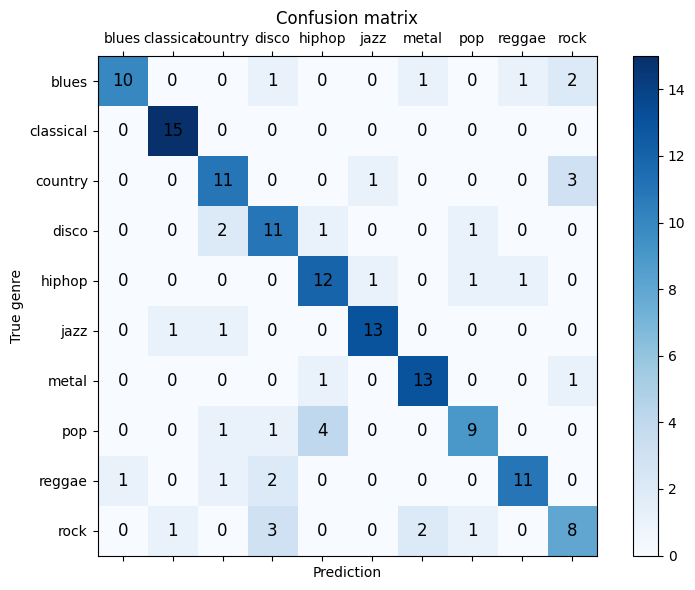

In [6]:
import matplotlib.pyplot as plt
test_accuracy = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred, average='macro')
test_f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision (macro): {test_precision:.4f}")
print(f"F1 Score (macro): {test_f1:.4f}")
print("Confusion Matrix:")

class_names = test_dataset.label_map.keys()

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(conf_matrix, cmap='Blues')
fig.colorbar(cax)
# Dodaj etykiety osi
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Dodaj liczby do komórek
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        ax.text(j, i, str(conf_matrix[i][j]),
                va='center', ha='center', color='black', fontsize=12)

# Oznaczenia osi
plt.xlabel('Prediction')
plt.ylabel('True genre')
plt.title('Confusion matrix')
plt.tight_layout()
plt.show()


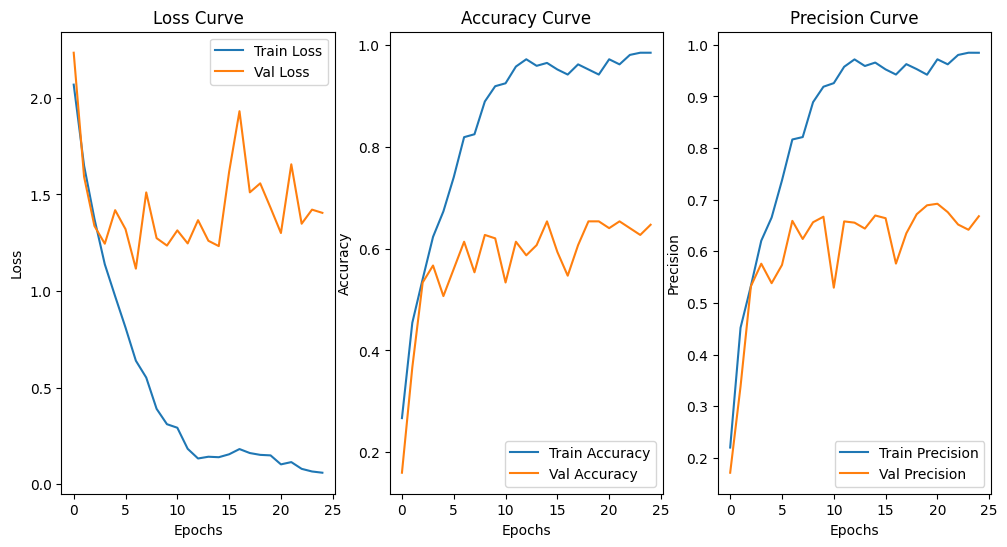

In [7]:
# Plotting the Loss and Accuracy curves
plt.figure(figsize=(12, 6))

num_epochs = len(train_losses)
# Losses
plt.subplot(1, 3, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(num_epochs), val_accuracies, label='Val Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Precision
plt.subplot(1, 3, 3)
plt.plot(range(num_epochs), train_precisions, label='Train Precision')
plt.plot(range(num_epochs), val_precisions, label='Val Precision')
plt.title("Precision Curve")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()

plt.show()